In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
data=pd.read_csv('Bank_Personal_Loan_Modelling-1.csv')

In [6]:
#1.Read the column description and ensure you understand each attribute well
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal_Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [7]:
data.apply(lambda x: len(x.unique()))

ID                    5000
Age                     45
Experience              47
Income                 162
ZIP Code               467
Family                   4
CCAvg                  108
Education                3
Mortgage               347
Personal_Loan            2
Securities Account       2
CD Account               2
Online                   2
CreditCard               2
dtype: int64

In [8]:
#2. Study the data distribution in each attribute, share your findings.

#Annswer: 

#Attributes explanation:

#ID: Customer account ID, no practical meaning

#Age: customer age, numerical variables

#Experience: work experience, numerical variables

#Income: annual income, numerical variable

#ZIP_Code: Zip code of the customer's location, which needs to be treated as a string

#Family: number of households, discrete numerical variables

#CCAvg: monthly credit card repayment amount, numerical variable

#Education: education level, discrete numerical variables, 1 for ungraduate, 2 for graduates, 3 for senior graduates

#Mortgage: Mortgage number, numerical variable

#Personal_Loan: Whether to participate in this mortgage, Boolean variable

#Securities_Account: Is there a secret account at the bank, a Boolean variable?

#CD_Account: Is there a deposit account at the bank, a Boolean variable?

#Online: Whether to open online banking, Boolean variables

#CreditCard: Is there a credit card, a Boolean variable?

In [9]:
#Through observation, it is found that there is a negative value of work experience. 
#According to experience, work experience and age and education level are highly correlated, 
#so the value of negative work experience is converted into the median value of the same age and education level.

count    5000.000000
mean       20.241800
std        11.326208
min         0.000000
25%        10.000000
50%        20.000000
75%        30.000000
max        43.000000
Name: Experience, dtype: float64


C:\Users\Bhanushree\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


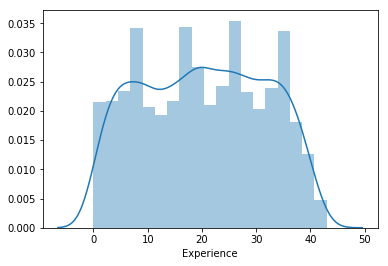

In [10]:
dfExp=data.query('Experience>0')
negExp=data.Experience<0
mylist=data.loc[negExp]['ID'].tolist()
for id in mylist:
    age=data.query('ID==@id').Age.tolist()[0]
    education=data.query('ID==@id').Education.tolist()[0]
    df_filtered=dfExp.query('Age==@age and Education==@education')
    exp=df_filtered['Experience'].median()
    if exp is np.nan:
        exp=data.Experience.median()
    data.loc[data.query('ID==@id').index, 'Experience'] = exp
    
print(data.Experience.describe())
sns.distplot(data.Experience)

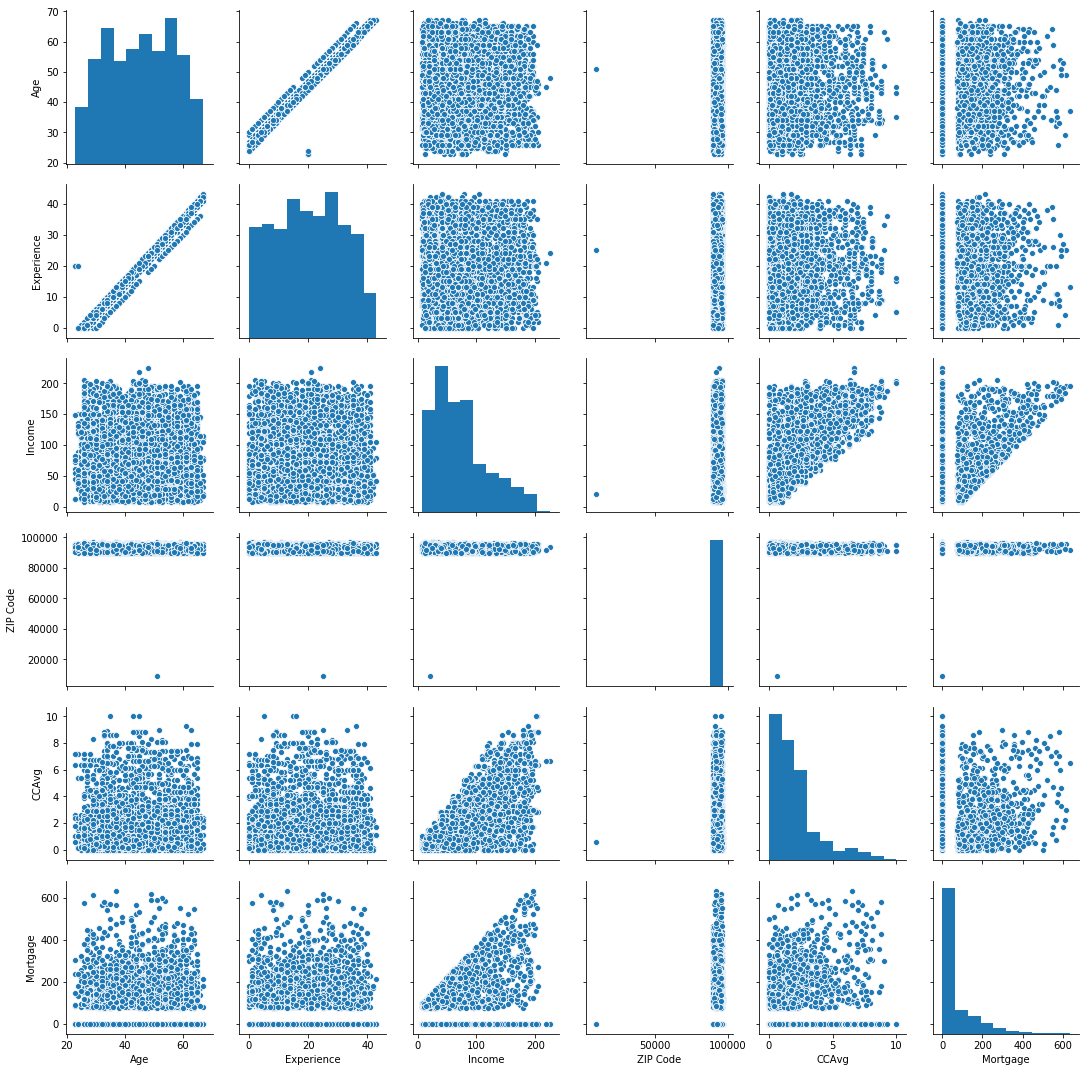

In [11]:
#the relationship between individual numeric variables
sns.pairplot(data.loc[:,['Age','Experience','Income','ZIP Code','CCAvg','Mortgage']])

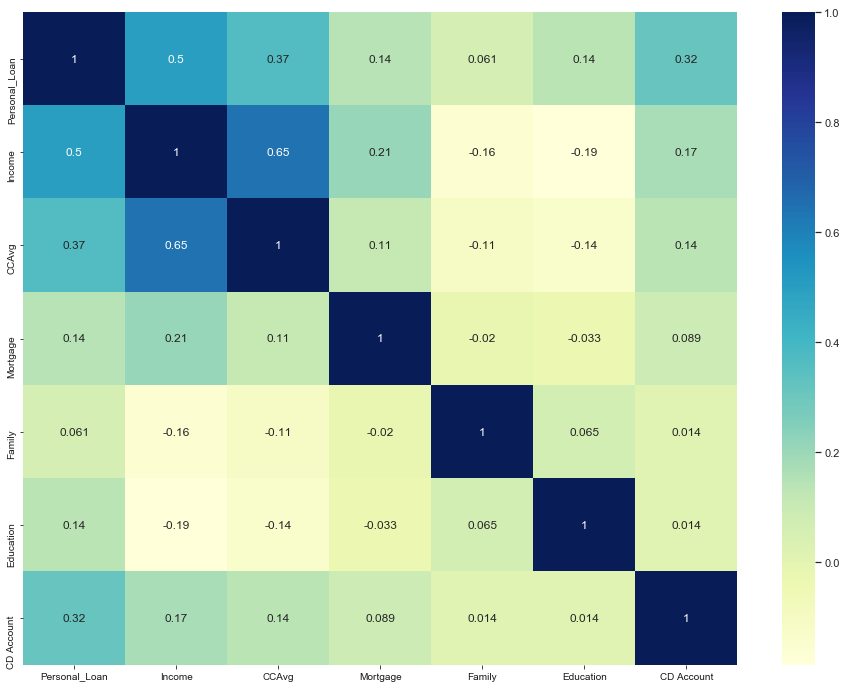

In [12]:
#Correlation analysis of seven variables using heat map
f, ax = plt.subplots(figsize=(16, 12))
sns.set()
sns.heatmap(data[['Personal_Loan','Income','CCAvg','Mortgage','Family',\
'Education','CD Account']].corr(),annot=True,cmap='YlGnBu')

In [13]:
print(data.groupby('Personal_Loan')['Income'].agg(['count',np.mean,np.std]))

               count        mean        std
Personal_Loan                              
0               4520   66.237389  40.578534
1                480  144.745833  31.584429


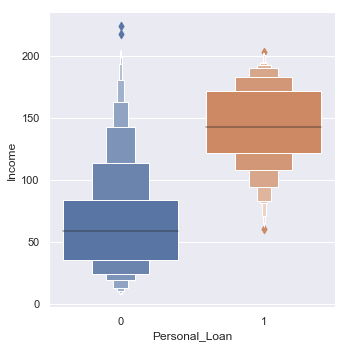

In [14]:
sns.catplot('Personal_Loan','Income',data=data,kind='boxen')

In [15]:
#As can be seen from the two figures, high-income people are more willing to apply for loans than low-income people, 
#which is consistent with our common sense. However, this picture has a flaw. 
#It is impossible to see the ratio of loan applications for each income segment, so we need to do some further processing.

C:\Users\Bhanushree\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Bhanushree\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


                    mean  count
Income Bins                    
(7.999, 18.0]   0.000000    278
(18.0, 22.0]    0.000000    229
(22.0, 29.0]    0.000000    295
(29.0, 33.0]    0.000000    227
(33.0, 39.0]    0.000000    283
(39.0, 42.0]    0.000000    237
(42.0, 45.0]    0.000000    224
(45.0, 52.0]    0.000000    229
(52.0, 59.0]    0.000000    278
(59.0, 64.0]    0.007407    270
(64.0, 71.0]    0.012987    231
(71.0, 78.0]    0.008403    238
(78.0, 82.0]    0.007905    253
(82.0, 88.3]    0.043860    228
(88.3, 98.0]    0.066929    254
(98.0, 113.0]   0.179775    267
(113.0, 128.0]  0.275862    232
(128.0, 145.0]  0.395437    263
(145.0, 170.0]  0.412766    235
(170.0, 224.0]  0.526104    249


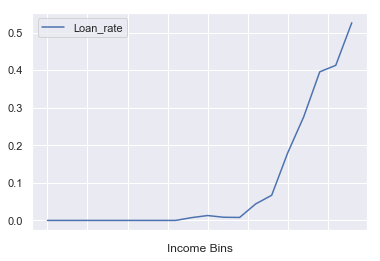

In [16]:
#View changes in loan opening rates as income grows
data['Income Bins']=pd.qcut(data.Income,20)
print(data.groupby('Income Bins')['Personal_Loan'].agg({'mean':np.mean,'count':'count'}))
data.groupby('Income Bins')['Personal_Loan'].agg({'Loan_rate':np.mean}).plot()

In [17]:
#Conclusion: It can be seen from the figure that when the annual income exceeds 82, the willingness to borrow will increase by more than 5 times.
#When the income exceeds 98, the willingness to borrow will increase by nearly three times, and the higher the income, the more willingness of the loan. Strong.

In [18]:
from sklearn.model_selection import train_test_split
data['Income Bins']=pd.qcut(data.Income,10,labels=range(0,10)).astype(int)
data['CCAvg Bins']=pd.qcut(data.CCAvg,10,labels=range(0,10)).astype(int)
data['Mortgage Bins']=pd.cut(data.Mortgage,10,labels=range(0,10)).astype(int)

In [19]:
data['Income_110']=np.where(data.Income>110,1,0)
data['CCAvg_3']=np.where(data.CCAvg>3,1,0)

In [20]:
columns=data.columns.drop(['ID','Age','Experience','Income','ZIP Code','CCAvg','Mortgage','Personal_Loan','Securities Account','Online','CreditCard'])
train=data[columns]
y=data.Personal_Loan.values
X_train,X_test,y_train,y_test=train_test_split(train,y,random_state=0)
print(X_train.shape)
print(y_train.shape)

(3750, 8)
(3750,)


In [21]:
train_set, test_set, train_labels, test_labels = train_test_split(train, y, test_size=0.30, random_state=1)

In [22]:
model = LogisticRegression(solver='lbfgs' , max_iter=5000 , multi_class='multinomial')
model.fit(train_set, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
model.score(train_set , train_labels)      # performance on test data

0.9651428571428572

In [24]:
test_pred = model.predict(test_set)

print(metrics.classification_report(test_labels, test_pred))
print(metrics.confusion_matrix(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1351
           1       0.91      0.66      0.77       149

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.94      0.83      0.87      1500
weighted avg       0.96      0.96      0.96      1500

[[1341   10]
 [  50   99]]


In [25]:
# Invoking the NB Gaussian function to create the model
# fitting the model in the training data set
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(train_set, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
model.score(train_set , train_labels)      # performance on test data

0.892

In [27]:
test_pred = model.predict(test_set)

print(metrics.classification_report(test_labels, test_pred))
print(metrics.confusion_matrix(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1351
           1       0.42      0.76      0.54       149

   micro avg       0.87      0.87      0.87      1500
   macro avg       0.70      0.82      0.74      1500
weighted avg       0.92      0.87      0.89      1500

[[1198  153]
 [  36  113]]


In [33]:
from sklearn import metrics
metrics.confusion_matrix(y_test,predicted_labels)

array([[1132,   10],
       [   9,   99]], dtype=int64)

In [1]:
#From the point of view of accuracy and error range, the staking method is indeed superior to the gradient hoist, but the AUC value of the stacking has a huge landslide. 
#It is speculated that the threshold is in a certain area of change, and the variation of the false positive is abnormal.
#After comprehensive consideration, the Logistic Regression is selected as the final model without considering the marketing cost.